## BERT Sentiment Analysis

In [4]:
!pip install tensorflow-text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [6]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ChatBot/all_data.csv", encoding='ISO-8859-1')
df.head(5)

,Sentiment,Sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [7]:
df.groupby('Sentiment').describe()

Sentence                                                            \
             count unique                                                top   
Sentiment                                                                      
negative       604    604  The international electronic industry company ...   
neutral       2878   2872  SSH Communications Security Corporation is hea...   
positive      1363   1363  With the new production plant the company woul...   

                
          freq  
Sentiment       
negative     1  
neutral      2  
positive     1

In [8]:
df['Sentiment'].value_counts()

neutral     2878
positive    1363
negative     604
Name: Sentiment, dtype: int64

In [9]:
2878 + 1363 + 604
print(2878/4845)
print(1363/4845)
print(604/4845)

0.5940144478844169
0.28132094943240454
0.12466460268317854


#### 60% Neutral
#### 28% Positive
#### 12% Negative

In [10]:
df_negative = df[df['Sentiment']=='negative']
df_negative.shape

(604, 2)

In [11]:
df_positive = df[df['Sentiment']=='positive']
df_positive.shape

(1363, 2)

In [12]:
df_neutral = df[df['Sentiment']=='neutral']
df_neutral.shape

(2878, 2)

In [13]:
df_positive_downsampled = df_positive.sample(df_negative.shape[0])
df_positive_downsampled.shape

(604, 2)

In [14]:
df_neutral_downsampled = df_neutral.sample(df_negative.shape[0])
df_neutral_downsampled.shape

(604, 2)

In [15]:
df_balanced = pd.concat([df_neutral_downsampled,df_positive_downsampled, df_negative])
df_balanced.shape

(1812, 2)

In [16]:
import re
import nltk
import string
from nltk.corpus import stopwords

def preprocess(text):
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuations and numbers
    #text = re.sub('[^a-zA-Z]', '', text)
    #text = re.sub('``', '', text)

    return text



In [17]:
df['Sentiment']=df['Sentiment'].apply(preprocess)

In [18]:
df_balanced['Sentiment'].value_counts()

neutral     604
positive    604
negative    604
Name: Sentiment, dtype: int64

In [ ]:
df_balanced['Target']=df_balanced['Sentiment'].apply(lambda x: 0 if x=='negative' else (1 if x == 'neutral' else 2))
df_balanced.sample(10)

<h4>Split it into training and test data set</h4>

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Sentence'],df_balanced['Target'], stratify=df_balanced['Target'])#,  test_size=0.20, random_state=42)

In [23]:
X_train.head(10)

52      Within the framework of the partnership , Noki...
1342    Stonesoft is a global provider of proven , nex...
739     `` Our customer has been satisfied with Baswar...
4305    And Ogden reportedly will shell out $ 4.2 mill...
1659         The total donation amount is EUR 1,115,000 .
4640    ADPnews - Aug 3 , 2009 - Finnish media group I...
4385    A high court in Finland has fined seven local ...
1614    The company had earlier said that it was consi...
2270    AUSTIN , Texas , Sept. 6 -- Texas Department O...
4601    The two companies will also partner in further...
Name: Sentence, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [35]:
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/albert_en_preprocess/3')
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [25]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.71745336,  0.88082975]], dtype=float32)>

In [30]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
#l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
l = tf.keras.layers.Dense(3, activation='softmax', name='output')(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_word_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [32]:
len(X_train)

1359

In [33]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=METRICS)
#model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

<h4>Train the model</h4>

In [34]:
X_train.shape

(1359,)

In [35]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
43/43 [==============================] - 25s 336ms/step - loss: 1.1535 - accuracy: 0.3279
Epoch 2/50
43/43 [==============================] - 15s 341ms/step - loss: 1.0720 - accuracy: 0.3311
Epoch 3/50
43/43 [==============================] - 15s 342ms/step - loss: 1.0333 - accuracy: 0.3299
Epoch 4/50
43/43 [==============================] - 15s 357ms/step - loss: 1.0114 - accuracy: 0.3319
Epoch 5/50
43/43 [==============================] - 14s 334ms/step - loss: 0.9891 - accuracy: 0.3333
Epoch 6/50
43/43 [==============================] - 14s 336ms/step - loss: 0.9607 - accuracy: 0.3353
Epoch 7/50
43/43 [==============================] - 15s 351ms/step - loss: 0.9480 - accuracy: 0.3282
Epoch 8/50
43/43 [==============================] - 15s 353ms/step - loss: 0.9478 - accuracy: 0.3321
Epoch 9/50
43/43 [==============================] - 15s 352ms/step - loss: 0.9255 - accuracy: 0.3365
Epoch 10/50
43/43 [==============================] - 15s 353ms/step - loss: 0.9174 - accura

In [36]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 10s 400ms/step - loss: 0.7862 - accuracy: 0.3333


[0.7862398028373718, 0.3333333432674408]

In [54]:
X_test.shape

(453,)

In [66]:
y_predicted = model.predict(X_test)

15/15 [==============================] - 7s 452ms/step


In [75]:
y_predicted.shape
y_predicted_labels = np.argmax(y_predicted, axis=1)


In [76]:
print(y_predicted_labels[:10])
print(y_test.head(10))
y_predicted_labels.shape

[2 1 2 2 2 2 2 1 0 2]
4565    0
828     2
4418    0
705     2
548     2
1530    1
1792    2
1051    2
4067    0
4531    0
Name: Target, dtype: int64


(453,)

In [58]:
import numpy as np
y_predicted = np.where(y_predicted<0.1, 2 ,np.where(y_predicted>0.4, 0, 1))

In [59]:
y_test.shape

(453,)

In [60]:
y_pred.shape

(1359,)

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print(classification_report(y_test,y_predicted_labels))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       151
           1       0.62      0.42      0.50       151
           2       0.51      0.75      0.61       151

    accuracy                           0.61       453
   macro avg       0.63      0.61      0.60       453
weighted avg       0.63      0.61      0.60       453



In [81]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted_labels)
cm

array([[ 97,  16,  38],
       [ 16,  64,  71],
       [ 13,  24, 114]])

Text(50.722222222222214, 0.5, 'Truth')

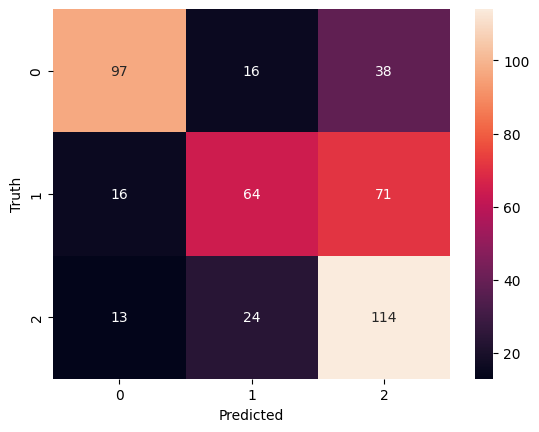

In [82]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [84]:
print(classification_report(y_test, y_predicted_labels))

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       151
           1       0.62      0.42      0.50       151
           2       0.51      0.75      0.61       151

    accuracy                           0.61       453
   macro avg       0.63      0.61      0.60       453
weighted avg       0.63      0.61      0.60       453



<h4>Inference</h4>

In [88]:
reviews = [
    'In June it sold a 30 percent stake to Nordstjernan , and the investment group has now taken up the option to acquire EQT ''s remaining shares .',
    'HELSINKI Thomson Financial - Shares in Cargotec fell sharply in early afternoon trade after the cargo handling group posted a surprise drop in April-June profits , which overshadowed the large number of new orders received during the three months .',
    'Last week , the Finnish metals and technology group announced plans to sell more than 80 percent of its technology unit to further the company ''s strategic goal of becoming the world ''s largest stainless steel maker .',
    'I don''t know how the impact was'
]
x= model.predict(reviews)
X_labels = np.argmax(x, axis=1)

print (X_labels)

1/1 [==============================] - 0s 264ms/step
[2 0 2 1]
